<a href="https://colab.research.google.com/github/busraparlakk/Auto-MPG/blob/main/Auto_MPG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli kütüphaneleri yükle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("Kütüphaneler başarıyla yüklendi!")

Kütüphaneler başarıyla yüklendi!


In [ ]:
# Veri setini yükle
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                'acceleration', 'model_year', 'origin', 'car_name']

df = pd.read_csv(url, names=column_names,
                 na_values='?', comment='\t',
                 sep='\s+', skipinitialspace=True)

print("Veri seti boyutu:", df.shape)
print("\nİlk 5 satır:")
df.head()

Veri seti boyutu: (398, 9)

İlk 5 satır:


,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


veri keşfi yapalım

In [ ]:
# Veri seti hakkında genel bilgiler
print("=== Veri Seti Bilgileri ===")
print(df.info())
print("\n=== İstatistiksel Özet ===")
print(df.describe())
print("\n=== Eksik Değerler ===")
print(df.isnull().sum())

=== Veri Seti Bilgileri ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car_name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB
None

=== İstatistiksel Özet ===
              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.

eksik değerleri temizleme

In [ ]:
# Horsepower'da eksik değerler var, bunları medyan ile doldur
df['horsepower'] = df['horsepower'].fillna(df['horsepower'].median())

# Car_name sütununu çıkar (tahmin için kullanmayacağız)
df = df.drop('car_name', axis=1)

print("Eksik değerler temizlendi!")
print("Güncel veri boyutu:", df.shape)
print("\nEksik değer kontrolü:")
print(df.isnull().sum())

Eksik değerler temizlendi!
Güncel veri boyutu: (398, 8)

Eksik değer kontrolü:
mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64


veri görselleştirme - hedef değişken

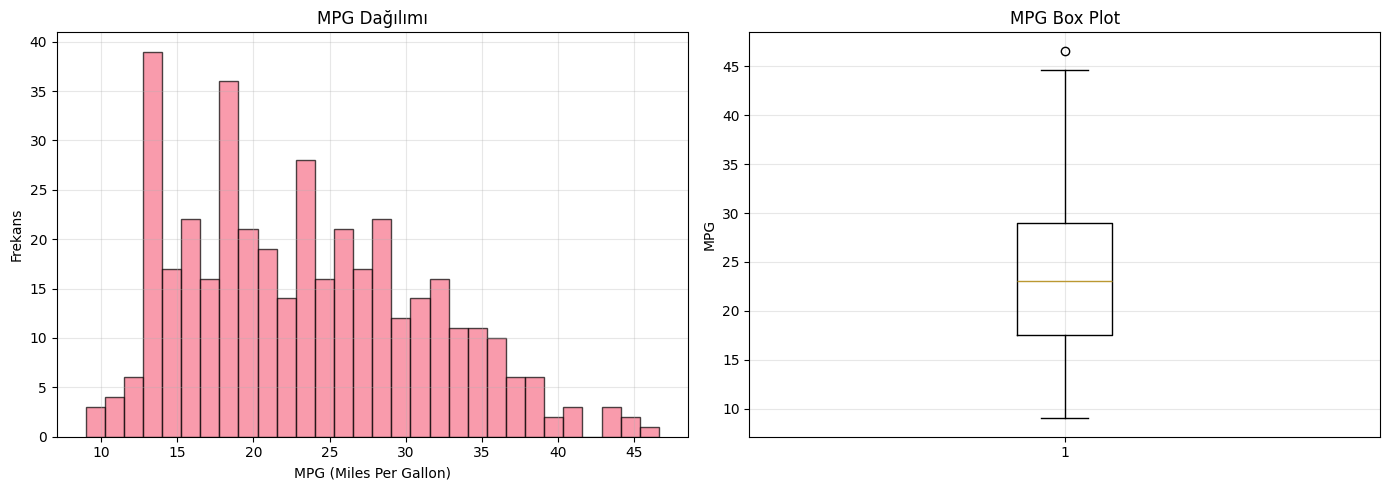

Ortalama MPG: 23.51
Medyan MPG: 23.00


In [ ]:
# MPG dağılımı
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(df['mpg'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('MPG (Miles Per Gallon)')
axes[0].set_ylabel('Frekans')
axes[0].set_title('MPG Dağılımı')
axes[0].grid(True, alpha=0.3)

axes[1].boxplot(df['mpg'])
axes[1].set_ylabel('MPG')
axes[1].set_title('MPG Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Ortalama MPG: {df['mpg'].mean():.2f}")
print(f"Medyan MPG: {df['mpg'].median():.2f}")

korelasyon analizi

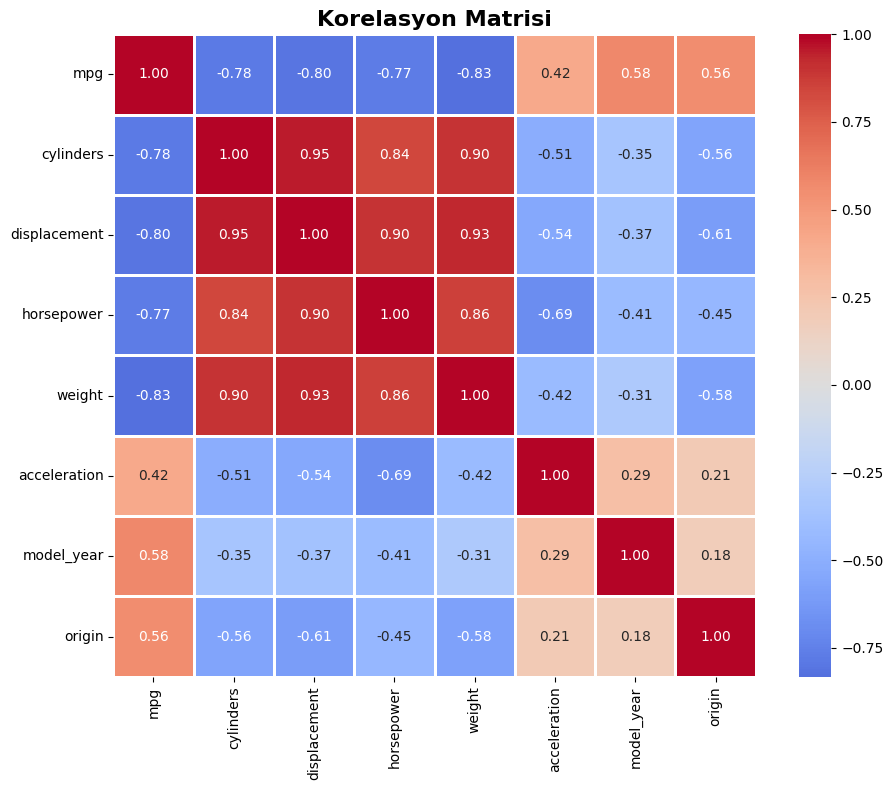


MPG ile en yüksek korelasyona sahip özellikler:
mpg             1.000000
model_year      0.579267
origin          0.563450
acceleration    0.420289
horsepower     -0.773453
cylinders      -0.775396
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64


In [ ]:
# Korelasyon matrisi
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=1)
plt.title('Korelasyon Matrisi', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nMPG ile en yüksek korelasyona sahip özellikler:")
print(correlation_matrix['mpg'].sort_values(ascending=False))

özellik ilişkileri görselleştirme

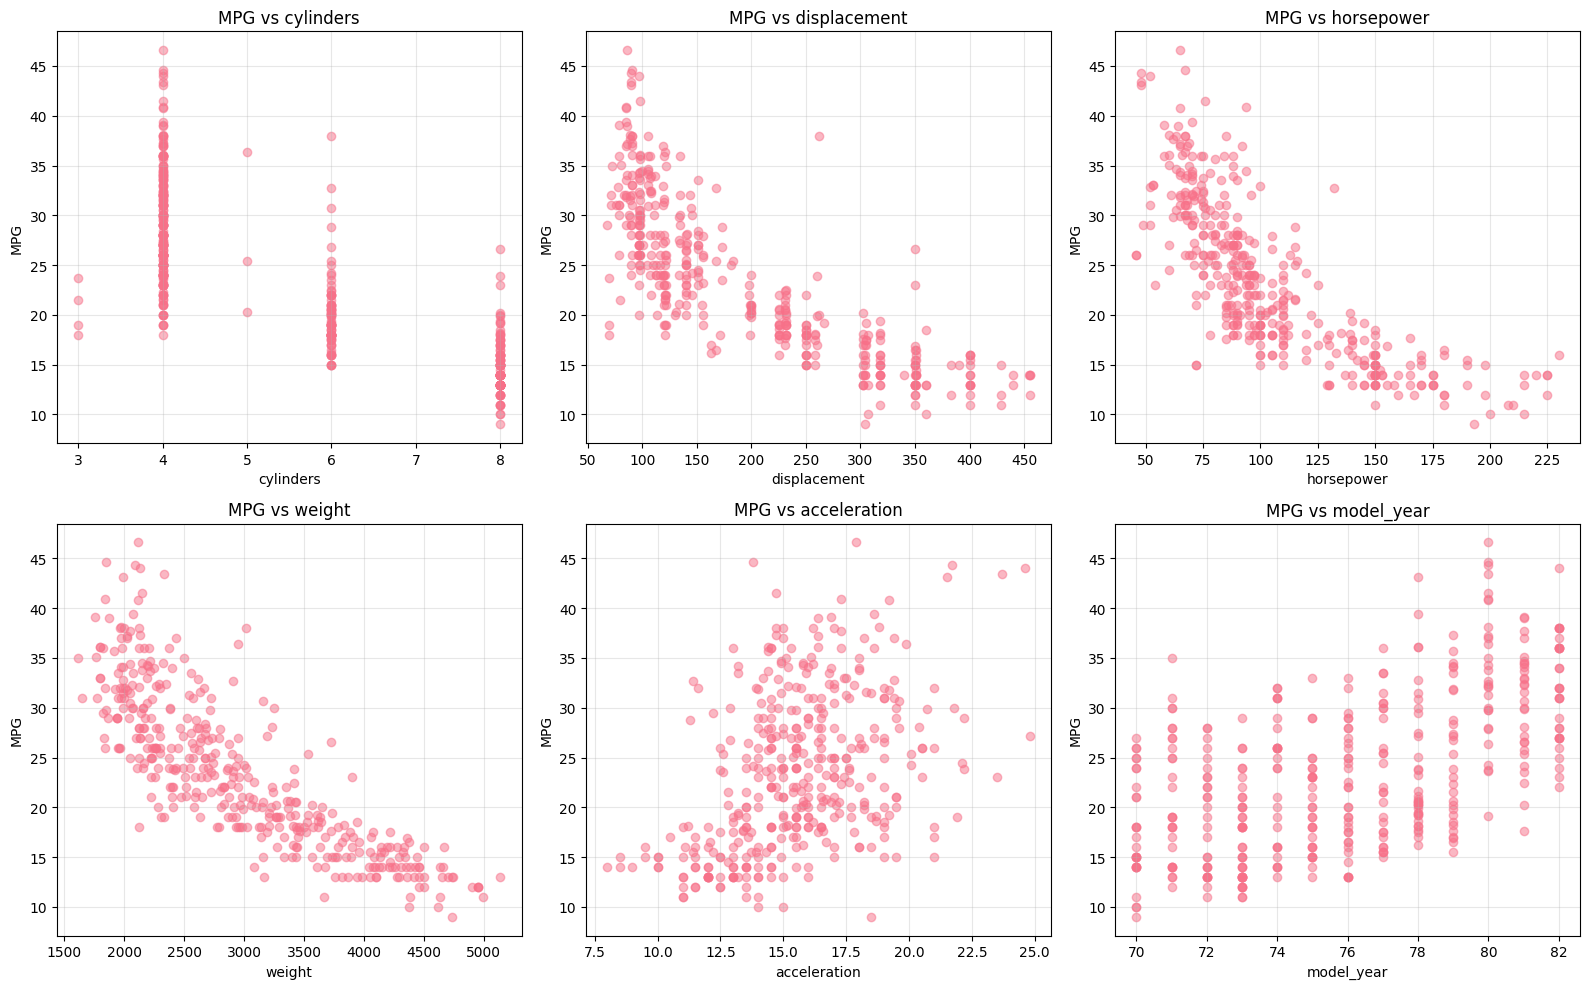

In [ ]:
# MPG ile diğer özellikler arasındaki ilişkiler
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']

for idx, feature in enumerate(features):
    axes[idx].scatter(df[feature], df['mpg'], alpha=0.5)
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('MPG')
    axes[idx].set_title(f'MPG vs {feature}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

veriyi hazırlama

In [ ]:
# Özellikler (X) ve hedef değişken (y) ayırma
X = df.drop('mpg', axis=1)
y = df['mpg']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Eğitim seti boyutu:", X_train.shape)
print("Test seti boyutu:", X_test.shape)

# Özellikleri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nÖzellikler ölçeklendirildi!")

Eğitim seti boyutu: (318, 7)
Test seti boyutu: (80, 7)

Özellikler ölçeklendirildi!


lineer regresyon

In [ ]:
# Linear Regression modeli
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Performans metrikleri
print("=== LINEAR REGRESSION ===")
print(f"Train R² Score: {r2_score(y_train, y_pred_train_lr):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_pred_test_lr):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_lr)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_lr)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_lr):.4f}")

=== LINEAR REGRESSION ===
Train R² Score: 0.8140
Test R² Score: 0.8475
Train RMSE: 3.4147
Test RMSE: 2.8632
Test MAE: 2.2554


random forest

In [ ]:
# Random Forest modeli
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)

# Performans metrikleri
print("=== RANDOM FOREST ===")
print(f"Train R² Score: {r2_score(y_train, y_pred_train_rf):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_pred_test_rf):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_rf)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_rf)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_rf):.4f}")

=== RANDOM FOREST ===
Train R² Score: 0.9810
Test R² Score: 0.9147
Train RMSE: 1.0917
Test RMSE: 2.1420
Test MAE: 1.5757


model-3 gradient boosting

In [ ]:
# Gradient Boosting modeli
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                      max_depth=4, random_state=42)
gb_model.fit(X_train_scaled, y_train)

# Tahminler
y_pred_train_gb = gb_model.predict(X_train_scaled)
y_pred_test_gb = gb_model.predict(X_test_scaled)

# Performans metrikleri
print("=== GRADIENT BOOSTING ===")
print(f"Train R² Score: {r2_score(y_train, y_pred_train_gb):.4f}")
print(f"Test R² Score: {r2_score(y_test, y_pred_test_gb):.4f}")
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_gb)):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_gb)):.4f}")
print(f"Test MAE: {mean_absolute_error(y_test, y_pred_test_gb):.4f}")

=== GRADIENT BOOSTING ===
Train R² Score: 0.9894
Test R² Score: 0.8927
Train RMSE: 0.8156
Test RMSE: 2.4023
Test MAE: 1.7223


model karşılaştırması

In [ ]:
# Tüm modelleri karşılaştır
models = {
    'Linear Regression': (y_pred_test_lr, r2_score(y_test, y_pred_test_lr)),
    'Random Forest': (y_pred_test_rf, r2_score(y_test, y_pred_test_rf)),
    'Gradient Boosting': (y_pred_test_gb, r2_score(y_test, y_pred_test_gb))
}

# Performans karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting'],
    'R² Score': [r2_score(y_test, y_pred_test_lr),
                 r2_score(y_test, y_pred_test_rf),
                 r2_score(y_test, y_pred_test_gb)],
    'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_test_lr)),
             np.sqrt(mean_squared_error(y_test, y_pred_test_rf)),
             np.sqrt(mean_squared_error(y_test, y_pred_test_gb))],
    'MAE': [mean_absolute_error(y_test, y_pred_test_lr),
            mean_absolute_error(y_test, y_pred_test_rf),
            mean_absolute_error(y_test, y_pred_test_gb)]
})

comparison_df = comparison_df.sort_values('R² Score', ascending=False)
print("=== MODEL KARŞILAŞTIRMASI ===")
print(comparison_df.to_string(index=False))

=== MODEL KARŞILAŞTIRMASI ===
            Model  R² Score     RMSE      MAE
    Random Forest  0.914668 2.141959 1.575688
Gradient Boosting  0.892668 2.402263 1.722340
Linear Regression  0.847530 2.863171 2.255363


en iyi model- tahmin görselleştirme

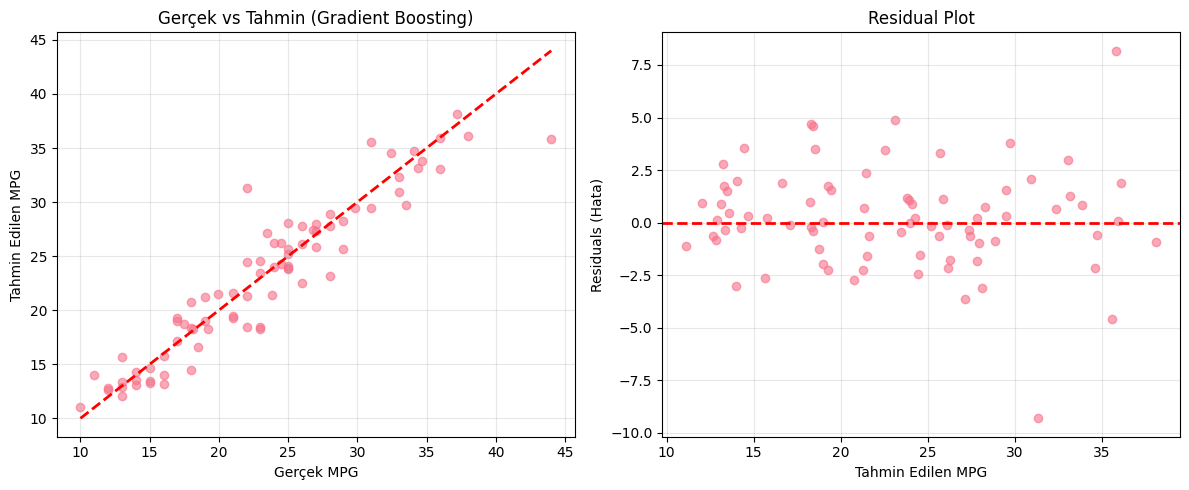

In [ ]:
# En iyi modeli seç (Gradient Boosting genelde en iyi sonuç verir)
best_predictions = y_pred_test_gb

# Gerçek vs Tahmin grafiği
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, best_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek MPG')
plt.ylabel('Tahmin Edilen MPG')
plt.title('Gerçek vs Tahmin (Gradient Boosting)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - best_predictions
plt.scatter(best_predictions, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Tahmin Edilen MPG')
plt.ylabel('Residuals (Hata)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

özellik önem sıralaması

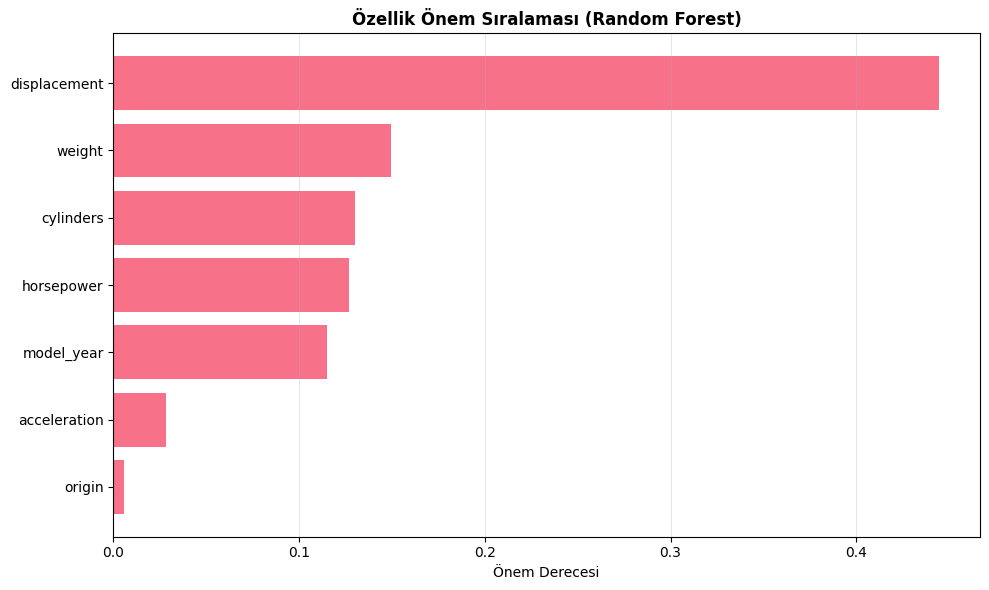

Özellik Önem Sıralaması:
     Feature  Importance
displacement    0.444384
      weight    0.149335
   cylinders    0.129926
  horsepower    0.126854
  model_year    0.114994
acceleration    0.028532
      origin    0.005974


In [ ]:
# Random Forest için özellik önemleri
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Önem Derecesi')
plt.title('Özellik Önem Sıralaması (Random Forest)', fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("Özellik Önem Sıralaması:")
print(feature_importance.to_string(index=False))

yeni tahmin yapma(örnek)

In [ ]:
# Yeni bir araba için tahmin yap
# Örnek: 6 silindir, 250 displacement, 100 horsepower, 3000 weight,
#        15 acceleration, 1978 model year, origin 1
new_car = np.array([[6, 250, 100, 3000, 15, 78, 1]])
new_car_scaled = scaler.transform(new_car)

# Tüm modellerle tahmin
lr_pred = lr_model.predict(new_car_scaled)[0]
rf_pred = rf_model.predict(new_car_scaled)[0]
gb_pred = gb_model.predict(new_car_scaled)[0]

print("=== YENİ ARABA TAHMİNİ ===")
print(f"Araba Özellikleri: {new_car[0]}")
print(f"\nLinear Regression Tahmini: {lr_pred:.2f} MPG")
print(f"Random Forest Tahmini: {rf_pred:.2f} MPG")
print(f"Gradient Boosting Tahmini: {gb_pred:.2f} MPG")
print(f"\nOrtalama Tahmin: {np.mean([lr_pred, rf_pred, gb_pred]):.2f} MPG")

=== YENİ ARABA TAHMİNİ ===
Araba Özellikleri: [   6  250  100 3000   15   78    1]

Linear Regression Tahmini: 24.86 MPG
Random Forest Tahmini: 20.27 MPG
Gradient Boosting Tahmini: 20.81 MPG

Ortalama Tahmin: 21.98 MPG
